## Using Package

In [84]:
#%pip install deap
import numpy as np
import pandas as pd
import random 
import time 
from scipy.integrate import solve_ivp
from scipy.stats import nbinom
from deap import base, creator, tools, algorithms
from tqdm import trange

In [115]:
# ------------------------------------------------------------------
# 1.  Data — replace with your own cumulative case matrix
# ------------------------------------------------------------------
cases = pd.read_csv("/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_count.csv",header=0)

# Extract Date and Gaines, remove if NA
case_df = (
    cases[["Update Date", "Gaines"]]          # keep only the needed cols
         .loc[1:]
         .assign(
             Gaines=lambda d: pd.to_numeric(d["Gaines"], errors="coerce"),
             Date=lambda d: pd.to_datetime(d["Update Date"])
         )
         .dropna(subset=["Gaines"])           # drop rows where Gaines is NaN
         .set_index("Date")                   # set date as index
         .drop(columns="Update Date")         # drop redundant col
         .sort_index()
)

# Prepare the proportion dataframe
prop_path = "/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_age_prop_ext.csv"
prop_df   = pd.read_csv(prop_path)
prop_df.rename(columns={prop_df.columns[0]: "Date"}, inplace=True)
prop_df[["Prop_0-4", "Prop_5-17", "Prop_18+"]] = prop_df[
    ["Prop_0-4", "Prop_5-17", "Prop_18+"]
].astype(float)
prop_df["Date"] = pd.to_datetime(prop_df["Date"])
prop_df = prop_df.set_index("Date").sort_index()

# Ensure both dataframes cover the same dates
case_aligned = case_df.reindex(prop_df.index)

# Keep only dates where we have a real case count
valid_idx      = case_aligned["Gaines"].notna()   # Boolean mask
case_filtered  = case_aligned.loc[valid_idx]      # drop NaNs
prop_filtered  = prop_df.loc[valid_idx]           # keep matching rows

# Multiply to get age-stratified counts
case_counts = (
    case_filtered["Gaines"].to_numpy().reshape(-1, 1) *
    prop_filtered[["Prop_0-4", "Prop_5-17", "Prop_18+"]].to_numpy()
).round().astype(int).tolist() 

# Time
date = case_df.index.to_series()
ts_cases = ((date - date.iloc[0]).dt.days + date.iloc[0].day).tolist()

n_age = 3
n_obs = len(case_counts)

/var/folders/vy/m4l1bmcs7xd4nmd991yq7qkr0000gn/T/ipykernel_89560/3258674084.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda d: pd.to_datetime(d["Update Date"])


In [21]:
N_raw = np.array([2341, 6500, 13682], dtype=int)   # population
V_raw = np.array([1988, 4536, 11616], dtype=int)   # one-dose total
E_raw = np.zeros(n_age, dtype=int)                 # exposed
I_raw = np.array([0, 1, 0], dtype=int)             # infectious

# Initialize y0 vector (length 10*n_age)
y0 = np.zeros(10 * n_age)

# Vaccination rate (daily proportion vaccinated)
v = 0.003

# Vaccine efficacy (leakey)
epsA = 1  
epsL = 0.97

# Exposed to infectious rate
sigma = float(np.random.gamma(shape=10, scale=1/80))

# Infectious to recovered rate
gamma1 = 1/3

# Underreporting rate
rep = 0.9

# Contact matrix (flattened row-major order) ##time-varying
C = np.array([
    1.4101, 2.5282, 4.9100,
    0.9290,11.0091, 6.0771,
    0.4884, 1.6387, 8.8461
])
C_flat = C.ravel(order="C")  

x_r = [v, epsA, epsL, sigma, gamma1, rep] + C.flatten(order='C').tolist()
x_i = [n_age] + N_raw.tolist() + V_raw.tolist() + E_raw.tolist() + I_raw.tolist()

In [76]:
# ------------------------------------------------------------------
# 2.  Deterministic SEIRHD ODE
# ------------------------------------------------------------------
def seirhd_ode(t, y, theta, x_r, x_i):
    """
    SEIRHD ODE with clearer indexing.

    Parameters
    ----------
    t : float
        Current time (unused but required by ODE solver signature).
    y : ndarray
        State vector ordered by age block:
            [S1, VS1, VR1, S2, V2, E, I, R, C] × n_age.
    theta : ndarray
        Age-specific β followed by scalar contact modifier:
            [β_0, …, β_{n_age−1}, con, (optional tail...)].
    x_r : ndarray
        Fixed real parameters:
            [v, epsA, epsL, sigma, gamma1, rep, *Cflat*].
    x_i : ndarray
        Fixed integer parameters:
            [n_age, N_pop_0, …, N_pop_{n_age−1}].
    """
    n_age = int(x_i[0])

    beta = np.asarray(theta[:n_age], dtype=float)  # β per age
    con  = float(theta[n_age])                    # contact modifier

    v, epsA, epsL, sigma, gamma1, rep = x_r[:6]
    Cmat = np.reshape(x_r[6:], (n_age, n_age))    # contact matrix

    N_pop = np.asarray(x_i[1:1 + n_age], dtype=float)

    dydt = np.zeros_like(y)

    for i in range(n_age):
        idx = i * 9
        S1, VS1, VR1, S2, V2, E, I, R, C = y[idx : idx + 9]

        # Force of infection λ_i
        lam_i = 0.0
        for j in range(n_age):
            jdx = j * 9
            Ij  = max(y[jdx + 6], 0.0)
            Nj  = N_pop[j] - y[jdx + 3] - y[jdx + 4]  # exclude protected
            lam_i += Cmat[i, j] * Ij / Nj

        lam   = beta[i] * lam_i
        v_eff = v if i == 0 else 0.0  # adjust if vaccination varies by age

        # Compartment flows
        dydt[idx + 0] = -lam * S1 - v_eff * S1
        dydt[idx + 1] = (1 - epsA) * v_eff * S1 - lam * VS1
        dydt[idx + 2] = epsA * v_eff * S1 - lam * (1 - epsL) * VR1
        dydt[idx + 3] = -v_eff * S2
        dydt[idx + 4] = v_eff * S2
        dydt[idx + 5] = lam * (S1 + VS1 + (1 - epsL) * VR1) - sigma * E
        dydt[idx + 6] = sigma * E - gamma1 * I
        dydt[idx + 7] = gamma1 * I
        dydt[idx + 8] = sigma * E  # cumulative cases

    return dydt

def build_y0(con):

    y0 = np.zeros(9 * n_age, dtype=float)

    S_base = N_raw - V_raw - E_raw - I_raw       # susceptibles (all flavours)

    for j in range(n_age):
        idx = 9 * j
        y0[idx + 0] = S_base[j]         * con
        y0[idx + 1] = (1 - epsA) * V_raw[j] * con
        y0[idx + 2] =      epsA  * V_raw[j] * con

        y0[idx + 3] = S_base[j]         * (1 - con)
        y0[idx + 4] = V_raw[j]          * (1 - con)

        y0[idx + 5] = E_raw[j]                       # E
        y0[idx + 6] = I_raw[j]                       # I
        y0[idx + 7] = 0.0                            # R
        y0[idx + 8] = I_raw[j]                       # cumulative cases
    return y0

#deterministic model
def run_model(best_pars,
              ts_obs = ts_cases,              # observation days (0,1,…)
              extra_days = 14,                # extend past last data point
              y0_fn = build_y0,               # builder that uses `con`
              x_r = x_r,                # fixed real data
              x_i = x_i):               # fixed integer data
    """
    best_pars = [β0, β1, β2, con, t0]
    Returns the full solve_ivp result object.
    """
    β0, β1, β2, con, t0 = best_pars
    theta = np.array([β0, β1, β2, con], dtype=float)

    # ---- initial state consistent with this con ------------------
    y0 = y0_fn(con)

    # ---- integration timeline (model time) ------------------------
    ts_obs = np.asarray(ts_obs, dtype=float)
    t_last_obs_model = ts_obs[-1] - t0          # shift to model clock
    if t_last_obs_model < 0:
        raise ValueError("t0 is larger than first observation day!")

    t_end  = t_last_obs_model + extra_days
    t_eval = np.arange(0, t_end + 1)            # daily output

    # ---- solve the system ---------------------------------------
    sol = solve_ivp(
        seirhd_ode,
        t_span=(0, t_end),
        y0=y0,
        args=(theta, x_r, x_i),
        t_eval=t_eval,
        dense_output=False
    )
    
    return sol


In [111]:
# ------------------------------------------------------------------
# 3.  Fitness  (negative log-likelihood under NB2 with fixed φ=20)
# ------------------------------------------------------------------
def fitness(individual):
    β0, β1, β2, con, t0 = individual
    if not (1 <= t0 <= 28):
        return (1e9,)                      # huge penalty
        
    theta = np.array([β0, β1, β2, con])         # whatever your ODE expects
    y0 = build_y0(con)          

    t_eval = np.array(ts_cases) - t0       # shift to model time
    if (t_eval < 0).any():
        return (1e9,)

    theta = np.array([β0, β1, β2, con], dtype=float)
    sol   = solve_ivp(seirhd_ode, (0, t_eval[-1]), y0,
                  args=(theta, x_r, x_i),    
                  t_eval=t_eval)

    # --- compare model vs data (your loss) ----------------------
    pred = sol.y[8::9, :].T           # your output slice
    resid = pred - case_counts              # same shape
    mse   = (resid**2).mean()               # divide by n_obs * n_age
    return (mse,)                                   # GA minimises this


In [146]:
# ------------------------------------------------------------------
# 4.  GA setup
# ------------------------------------------------------------------
bounds = [
    (0, 6),  # β0
    (0, 6),  # β1
    (0, 6),  # β2
    (0.1, 1),   # con
    (1, 28)     # t0  
]

low = [b[0] for b in bounds]
up  = [b[1] for b in bounds]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

#Produces one float drawn uniformly inside the gene’s allowed interval.
toolbox.register(
    "attr_float",
    lambda low, up: random.uniform(low, up)
)
#Returns a fully initialised parameters
toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    tuple(                           # <-- builds a 5-element tuple of lambdas
        lambda lo=low[i], hi=up[i]: random.uniform(lo, hi)
        for i in range(5)
    ),
    n=1
)
#Create a plain list of individuals by repeating toolbox.individual
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#Evaluate model error
toolbox.register("evaluate", fitness) 
toolbox.register("mate", tools.cxBlend, alpha=0.4) #crossover
toolbox.register("mutate", tools.mutPolynomialBounded,
                 eta=10, low=[b[0] for b in bounds],
                 up=[b[1] for b in bounds], indpb=0.2) #20% mutation
toolbox.register("select", tools.selTournament, tournsize=3) #Pushes the population toward lower-error individuals.

def clip_bounds(low, up):
    """
    Decorator that forces every gene of each offspring
    to stay within the supplied bounds.
    """
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for ind in offspring:
                for i, (lo, hi) in enumerate(zip(low, up)):
                    if ind[i] < lo:
                        ind[i] = lo
                    elif ind[i] > hi:
                        ind[i] = hi
            return offspring
        return wrapper
    return decorator

#  GA setup 
toolbox.decorate("mate",  clip_bounds(low, up))
toolbox.decorate("mutate", clip_bounds(low, up))

def round_t0():
    """Decorator factory: rounds gene #4 (t0) after crossover/mutation."""
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for ind in offspring:
                ind[4] = round(ind[4])
            return offspring
        return wrapper
    return decorator

toolbox.decorate("mate",   round_t0())
toolbox.decorate("mutate", round_t0())


/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [147]:
# ------------------------------------------------------------------
# 5.  Run GA
# ------------------------------------------------------------------
np.random.seed(42)
pop = toolbox.population(n=100) #population size =100
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", np.min); stats.register("median", np.median)

stats_t0 = tools.Statistics(lambda ind: ind[4])
stats_t0.register("median", np.median)
mstats = tools.MultiStatistics(fitness=stats, t0=stats_t0)

start = time.perf_counter()
pop, _ = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.6, # crossover probability
                             mutpb=0.4, # mutation probability
                             ngen=200, 
                             stats=mstats, verbose=False)
elapsed = time.perf_counter() - start  

best, = tools.selBest(pop, 1) #select one with minimum MSE

#MSE
best_mse = best.fitness.values[0]          # this _is_ the MSE
rmse     = best_mse**0.5                   # optional, for scale

print("Best parameters: β =", best[:3], "con =", best[3], "t0 =", best[4])
print(f"Best-fit MSE   : {best_mse:.4g}   (RMSE = {rmse:.4g})")
print(f"GA runtime: {elapsed:,.1f} seconds")              # nice human read-out


Best parameters: β = [3.8778029521783712, 0.12453008135861253, 0.16972258149955044] con = 0.10000000002756362 t0 = 3
Best-fit MSE   : 95.62   (RMSE = 9.779)
GA runtime: 98.0 seconds


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------------------------------------------
# 1.  Best-fit GA parameters
# -------------------------------------------------------------------
β0, β1, β2, con, t0 = best
theta = np.array([β0, β1, β2, con], dtype=float)
y0    = build_y0(con)

# -------------------------------------------------------------------
# 2.  Integrate the model on the shifted observation grid
# -------------------------------------------------------------------
t_eval = np.array(ts_cases) - t0         # model-time points (same as fitness)
sol    = solve_ivp(
           seirhd_ode,
           (0, t_eval[-1]),
           y0,
           args=(theta, x_r, x_i),
           t_eval=t_eval
         )

pred_cum = sol.y[8::9, :].T             # cumulative cases, shape (n_obs, n_age)

# -------------------------------------------------------------------
# 3.  Observed cumulative cases
# -------------------------------------------------------------------
obs_cum = np.asarray(case_counts, dtype=float)   # already cumulative

# *Safety check*: make sure lengths match (can happen if ODE failed early)
if obs_cum.shape[0] != pred_cum.shape[0]:
    n = min(obs_cum.shape[0], pred_cum.shape[0])
    pred_cum, obs_cum, t_eval = pred_cum[:n], obs_cum[:n], t_eval[:n]


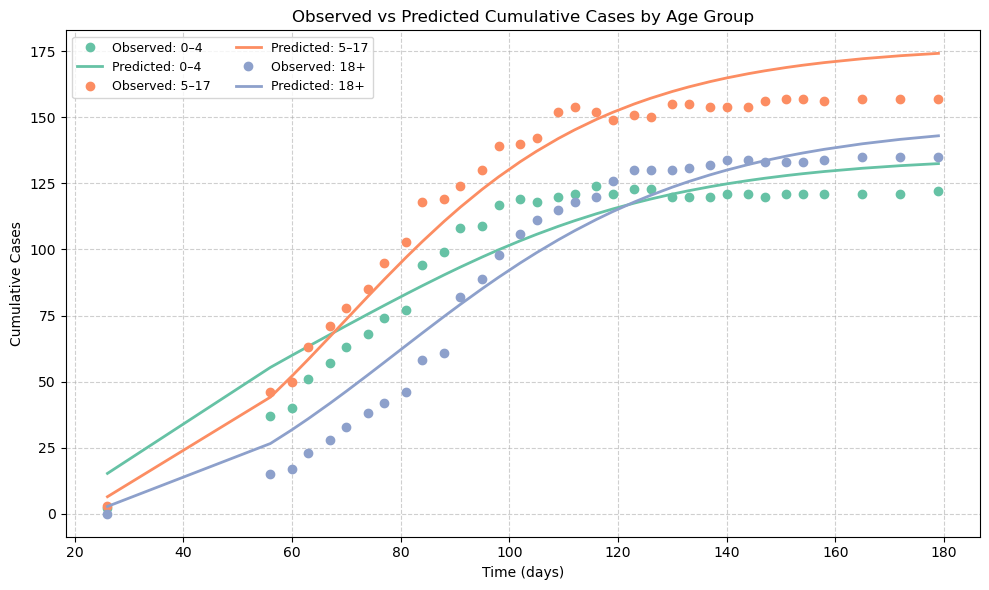

In [119]:
# -------------------------------------------------------------------
# 4.  Plot: predicted vs observed
# -------------------------------------------------------------------
age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))

for k in range(pred_cum.shape[1]):
    # Observed
    plt.plot(t_eval, obs_cum[:, k], 'o',
             markersize=6, color=colors(k),
             label=f'Observed: {age_labels[k]}')
    # Predicted
    plt.plot(t_eval, pred_cum[:, k], '-',
             linewidth=2, color=colors(k),
             label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases by Age Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

## Confidence Interval

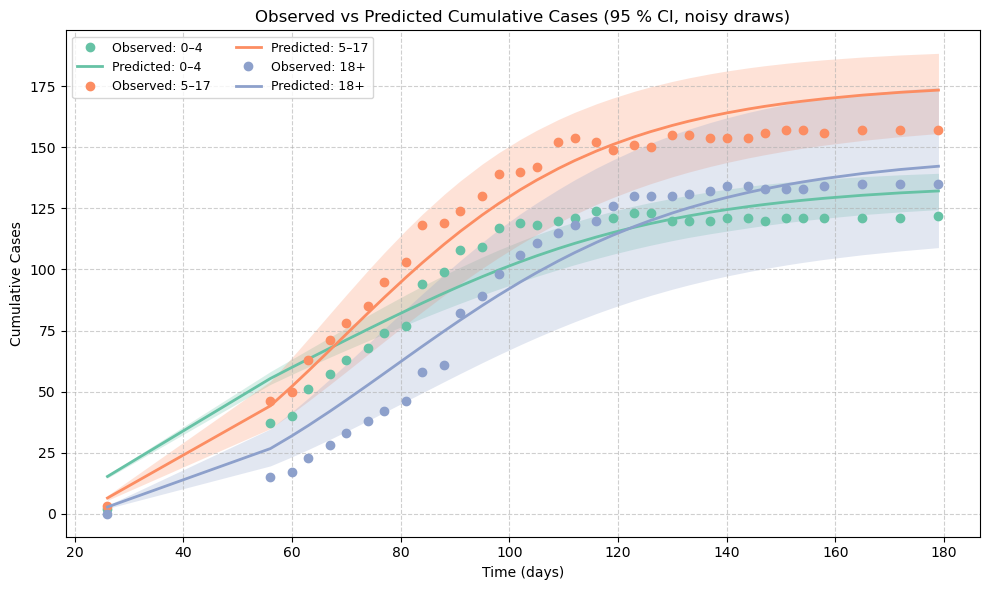

In [121]:
# ---------------------------------------------------------------
# Build 95 % CI with random-noise perturbations around GA optimum
# ---------------------------------------------------------------
# --- 1.  Settings ------------------------------------------------
n_draws     = 500                 # number of noisy parameter draws
pop_arr   = np.asarray(pop)          # (n_indiv, 5)
pop_sd    = pop_arr.std(axis=0)      # empirical σ
noise_sd  = 0.1 * pop_sd             # tighter: half of that spread

# --- 2.  Helper: forward model ----------------------------------
def predict_cum(params):
    β0, β1, β2, con, t0 = params
    theta = np.array([β0, β1, β2, con], dtype=float)
    y0    = build_y0(con)
    t_ev  = np.array(ts_cases) - t0
    sol   = solve_ivp(
        seirhd_ode, (0, t_ev[-1]), y0,
        args=(theta, x_r, x_i), t_eval=t_ev, vectorized=False
    )
    return sol.y[8::9, :].T        # (n_obs, n_age)

# --- 3.  Draw parameter ensemble --------------------------------
best_par   = np.array(best)        # GA optimum
noise_mat  = np.random.normal(0, noise_sd, size=(n_draws, 5))
par_draws  = best_par + noise_mat

#pred_list = []
#best_loss = best.fitness.values[0]
#tol = 1.30
#for p in par_draws:
#    loss = fitness(p)               # same objective GA used
#    if loss <= tol * best_loss:
#        pred_list.append(predict_cum(p))

pred_list  = [predict_cum(p) for p in par_draws]
pred_arr   = np.stack(pred_list)   # (n_draws, n_obs, n_age)

pred_mean  = pred_arr.mean(axis=0)
pred_low   = np.percentile(pred_arr,  2.5, axis=0)
pred_high  = np.percentile(pred_arr, 97.5, axis=0)

# --- 4.  Plot ----------------------------------------------------
age_labels = ['0–4', '5–17', '18+']
colors     = plt.get_cmap('Set2')
plt.figure(figsize=(10, 6))

for k in range(pred_mean.shape[1]):
    plt.fill_between(t_eval, pred_low[:, k], pred_high[:, k],
                     color=colors(k), alpha=0.25, linewidth=0)
    plt.plot(t_eval, obs_cum[:, k], 'o', markersize=6,
             color=colors(k), label=f'Observed: {age_labels[k]}')
    plt.plot(t_eval, pred_mean[:, k], '-', linewidth=2,
             color=colors(k), label=f'Predicted: {age_labels[k]}')

plt.xlabel('Time (days)')
plt.ylabel('Cumulative Cases')
plt.title('Observed vs Predicted Cumulative Cases (95 % CI, noisy draws)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


## Diagnosis

In [103]:
# ================================================================
# Diagnostics for GA fit: 95 % CI bands, Leave-One-Out CV,
# MSE path (mean ± CI) and runtime (mean ± CI)
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from deap import base, creator, tools, algorithms      # assumes GA already set up

# ------------------------------------------------
# 1.  Wrapper: run a GA once, return stats
# ------------------------------------------------
def run_ga(case_counts, ts_cases, ngen=200, pop_size=100,
           cxpb=0.6, mutpb=0.4, seed=None):

    if seed is not None:
        np.random.seed(seed)

    pop  = toolbox.population(n=pop_size)
    stats_f = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats_f.register("min", np.min); stats_f.register("median", np.median)
    stats_t = tools.Statistics(lambda ind: ind[4])
    stats_t.register("median", np.median)
    mstats  = tools.MultiStatistics(fitness=stats_f, t0=stats_t)

    t0_wall = time.perf_counter()
    pop, logbook = algorithms.eaSimple(pop, toolbox,
                                       cxpb=cxpb, mutpb=mutpb,
                                       ngen=ngen, stats=mstats,
                                       verbose=False)
    runtime = time.perf_counter() - t0_wall
    best, = tools.selBest(pop, 1)
    mse_path = logbook.chapters["fitness"].select("min")  # len = ngen+1

    pred_cum = predict_cum(best)

    return {"best": best, "runtime": runtime,
            "mse_path": np.asarray(mse_path, dtype=float),
            "pred_cum": pred_cum}


In [123]:
# ------------------------------------------------
# 2.  Repeat GA to get distribution of runtimes & MSE paths
# ------------------------------------------------
n_runs = 20
results = [run_ga(case_counts, ts_cases, seed=s) for s in range(n_runs)]

Runtime over 20 GA runs:
  mean = 89.87 s,  95 % CI = [81.24, 98.15] s

Final-generation MSE : 95.57  (95 % CI = [95.5, 95.63])


In [ ]:
runtimes = np.array([r["runtime"] for r in results])
mse_paths = np.stack([r["mse_path"] for r in results])  # (n_runs, ngen+1)

# --- runtime mean & 95 % CI
rt_mean = runtimes.mean()
rt_lo, rt_hi = np.percentile(runtimes, (2.5, 97.5))

# --- MSE path mean & 95 % CI
mse_mean = mse_paths.mean(axis=0)
mse_lo   = np.percentile(mse_paths,  2.5, axis=0)
mse_hi   = np.percentile(mse_paths, 97.5, axis=0)

print(f"Runtime over {n_runs} GA runs:")
print(f"  mean = {rt_mean:.2f} s,  95 % CI = [{rt_lo:.2f}, {rt_hi:.2f}] s\n")

final_mse_mean = mse_mean[-1]
final_mse_lo   = mse_lo[-1]
final_mse_hi   = mse_hi[-1]

print(f"Final-generation MSE : {final_mse_mean:.4g}  "
      f"(95 % CI = [{final_mse_lo:.4g}, {final_mse_hi:.4g}])")

In [128]:
import numpy as np
from scipy.stats import t

# --- make sure obs is a NumPy array once ------------------------
obs = np.asarray(case_counts, dtype=float)     # (n_obs, n_age)

# --- collect per-run metrics ------------------------------------
mae_vals  = []
rmse_vals = []

for r in results:                              # results already has 20 runs
    pred   = r["pred_cum"]                     # final model predictions
    resid  = pred - obs

    mae_vals.append(np.mean(np.abs(resid)))    # final MAE
    rmse_vals.append(np.sqrt(r["mse_path"][-1]))  # RMSE = √(final MSE)

mae_vals  = np.array(mae_vals)
rmse_vals = np.array(rmse_vals)

# --- mean ± 95 % CI helper --------------------------------------
def mean_ci(arr, alpha=0.05):
    mean = arr.mean()
    se   = arr.std(ddof=1) / np.sqrt(len(arr))
    h    = se * t.ppf(1 - alpha/2, df=len(arr)-1)
    return mean, mean - h, mean + h

mae_mean,  mae_lo,  mae_hi  = mean_ci(mae_vals)
rmse_mean, rmse_lo, rmse_hi = mean_ci(rmse_vals)

# --- print concise summary --------------------------------------
print(f"Final-generation metrics over {len(results)} GA runs:")
print(f"  MAE  : {mae_mean:.4g}  (95 % CI [{mae_lo:.4g}, {mae_hi:.4g}])")
print(f"  RMSE : {rmse_mean:.4g}  (95 % CI [{rmse_lo:.4g}, {rmse_hi:.4g}])")


Final-generation metrics over 20 GA runs:
  MAE  : 8.626  (95 % CI [8.599, 8.654])
  RMSE : 9.776  (95 % CI [9.775, 9.777])


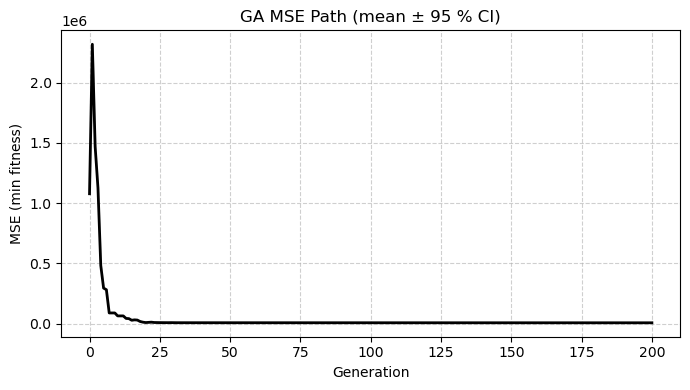

In [105]:
# ------------------------------------------------
# 3.  Plot MSE path with CI
# ------------------------------------------------
gens = np.arange(mse_mean.size)
plt.figure(figsize=(7, 4))
plt.fill_between(gens, mse_lo, mse_hi, color="lightgray", alpha=0.4)
plt.plot(gens, mse_mean, lw=2, color="black")
plt.xlabel("Generation")
plt.ylabel("MSE (min fitness)")
plt.title("GA MSE Path (mean ± 95 % CI)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


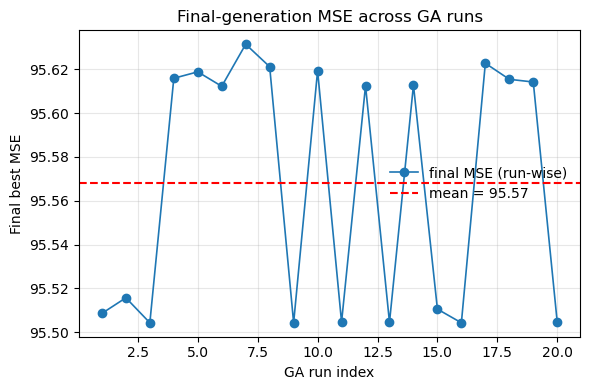

In [139]:
# ---------------------------------------------------------------
# Plot final-generation MSE for each GA run
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

final_mse = mse_paths[:, -1]          # one value per run
runs      = np.arange(1, len(final_mse) + 1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(runs, final_mse, 'o-', lw=1.2, label="final MSE (run-wise)")
ax.axhline(final_mse.mean(), color='red', ls='--',
           label=f"mean = {final_mse.mean():.4g}")

ax.set_xlabel("GA run index")
ax.set_ylabel("Final best MSE")
ax.set_title("Final-generation MSE across GA runs")
ax.grid(alpha=0.3)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()




In [130]:
#coverage
from scipy.spatial.distance import pdist
import numpy as np

pop, logbook = algorithms.eaSimple(pop, toolbox,
                                   cxpb=0.6, mutpb=0.4,
                                   ngen=200, stats=mstats, verbose=False)

# ---- assume you have `pop` (final population) and logbook (mse_path) ----
pop_arr   = np.asarray(pop)                       # (n_indiv, n_params)
spread    = pop_arr.std(axis=0)                   # per-param SD
avg_dist  = pdist(pop_arr).mean()                 # mean pairwise distance

# fitness plateau detection over last K generations
K = 10
best_path = logbook.chapters["fitness"].select("min")
plateau   = np.max(best_path[-K:]) - np.min(best_path[-K:]) < 1e-6

print("Fitness plateau (K=10)?", plateau)
print("Parameter spread (SD):  ", spread)
print("Avg pairwise distance:  ", avg_dist)


Fitness plateau (K=10)? False
Parameter spread (SD):   [0.09219808 0.03035314 0.05484796 0.01039688 0.2       ]
Avg pairwise distance:   0.14945682719587428
